In [2]:
import pickle
import json
import numpy as np
import os

In [23]:
dir = 'deep_nutr_vlp/base/food_test'
with open(f'../out/models/{dir}/out_nutr.json','r') as f:
    out_nutr = json.load(f)
with open(f'../out/models/{dir}/out_ingrs.json','r') as f:
    out_ingrs = json.load(f)

In [24]:
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/food.com_nutr_g_per_recipe.json') as f:
    nutr_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_food_ids_per_recipes.json') as f:
    food_ids_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_weighted_food_ids_per_recipes.json') as f:
    weighted_food_ids_per_recipes = json.load(f)

In [25]:
def cal_iou(input_1, input_2):
    input_1 = set(input_1)
    input_2 = set(input_2)
    u = input_1.union(input_2)
    i = input_1.intersection(input_2)
    return len(i) / len(u)
def cal_weighted_iou(input_1, input_2, w_1, w_2):
    all_weight = sum(w_1) + sum(w_2)
    intersect_weight = 0.
    for i, ingr in enumerate(input_1):
        if ingr in input_2:
            j = input_2.index(ingr)
            intersect_weight += w_1[i] + w_2[j]
    return intersect_weight / all_weight

In [26]:
gts = {
    'energy': [],
    'fat': [],
    'carb': [],
    'protein': [],
}
preds = {
    'energy': [],
    'fat': [],
    'carb': [],
    'protein': [],
}
absolute_errors = {
    'energy': [],
    'fat': [],
    'carb': [],
    'protein': [],
}
percentage_errors = {
    'energy': [],
    'fat': [],
    'carb': [],
    'protein': [],
}

for recipe_id, pred_nutr in out_nutr.items():
    gt_nutr = nutr_per_recipes[recipe_id]
    for nutr_name in gts.keys():
        gts[nutr_name].append(gt_nutr[nutr_name])
        preds[nutr_name].append(pred_nutr[nutr_name])
        absolute_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name]))
        if gt_nutr[nutr_name] < 0.1:
            percentage_errors[nutr_name].append(0)
        else:
            percentage_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/gt_nutr[nutr_name])

ious = []
# weighted_ious = []
for recipe_id, pred_ingrs in out_ingrs.items():
    real_pred_ingrs = [pred_ingr for pred_ingr in pred_ingrs]
    ious.append(cal_iou(food_ids_per_recipes[recipe_id],real_pred_ingrs))
    # weighted_ious.append(cal_weighted_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result],weighted_food_ids_per_recipes[recipe_id]['weight'],weighted_food_ids_per_recipes[result]['weight']))


In [27]:
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')
iou = sum(ious)/len(ious)
print(f'{iou*100:.02f}%')

energy: MAE = 54.87, MAPE = 0.35, SE = 100.39
fat: MAE = 4.96, MAPE = 1.39, SE = 7.14
carb: MAE = 7.00, MAPE = 0.71, SE = 15.99
protein: MAE = 2.19, MAPE = 0.61, SE = 3.84
0.77
32.11%


0.7678
0.6119
0.8224
0.7103


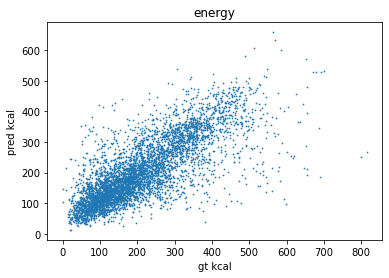

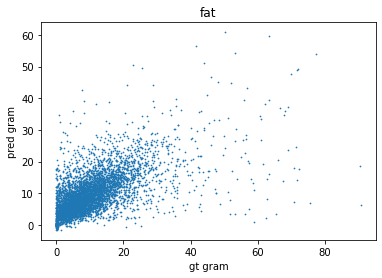

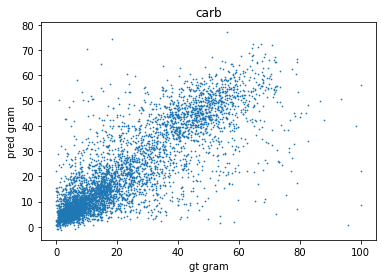

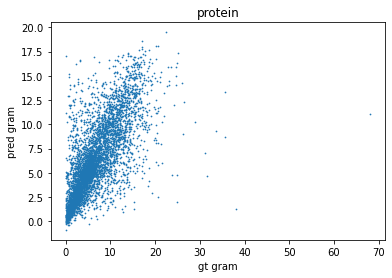

In [7]:
import matplotlib.pyplot as plt

for nutr_name in gts.keys():
    cc = np.corrcoef(gts[nutr_name],preds[nutr_name])[0,1]
    print(f'{cc:.04f}')
    plt.figure()
    plt.scatter(gts[nutr_name],preds[nutr_name],s=0.5)
    if nutr_name == 'energy':
        plt.xlabel('gt kcal')
        plt.ylabel('pred kcal')
        # plt.xlim((0,2500))
        # plt.ylim((0,2500))
    else:
        plt.xlabel('gt gram')
        plt.ylabel('pred gram')
        # plt.xlim((0,200))
        # plt.ylim((0,200))
    plt.title(nutr_name)